# Zero-Shot CLIP for Facial Expression Classification

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/H11Maitree/Facial-Expression-Classification-CLIP/blob/main/Zero_Shot_CLIP_for_Facial_Expression_Classification.ipynb)

author: [Maitree HIRUNTEEYAKUL (matt.h@my.cityu.edu.hk)](https://github.com/h11maitree)

---
## Preface
**This material is adopted/modified from OpenAI's self-contained notebook named ["Interacting with CLIP"](https://colab.research.google.com/github/openai/clip/blob/master/notebooks/Interacting_with_CLIP.ipynb)** where it make use of CLIP to demo the process of
- Tokenization on Text
- Preview CLIP Similarlity (Relation of Tokenized Text and Image)
- Label-to-Prompt Constuction
- Zero-Shot Prediction given Destinated Class Labels

which is the product of research named ["Learning Transferable Visual Models From Natural Language Supervision"](https://arxiv.org/abs/2103.00020)

---
## Introduction
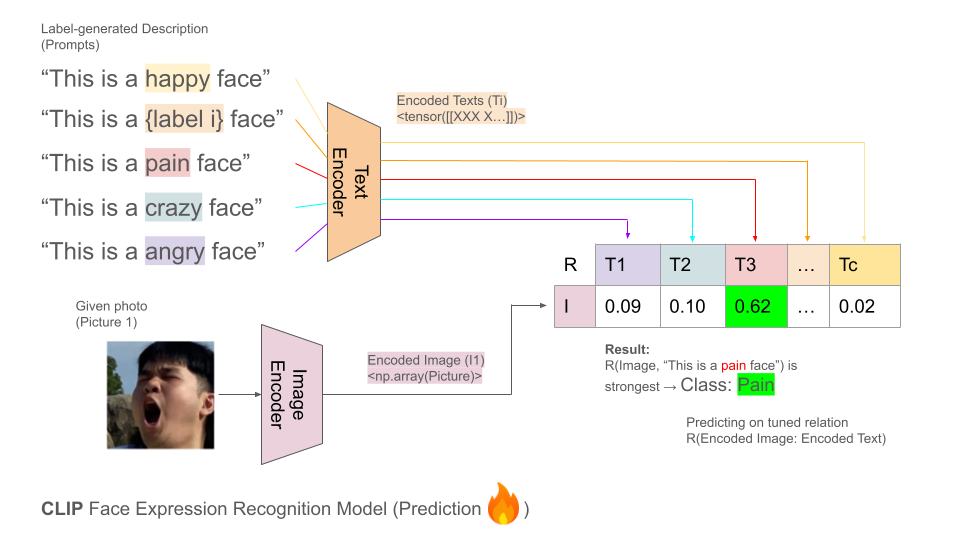

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary (face) image and description (text) inputs, constucting Prompt from the model and perform zero-shot **Facial Expression Classification** given image and labels.


# Preparation for Colab

**[IMPORTANT!] Make sure you're running a GPU runtime;**

For Google Colab user, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu.

1. On the top right conor you will find Runtime Setting tap, Select `Change Runtime Type`

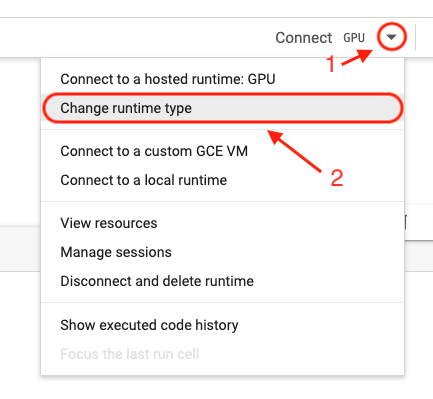

2. Ensure to choose any `GPU` avaliable option (do not choose `CPU`)

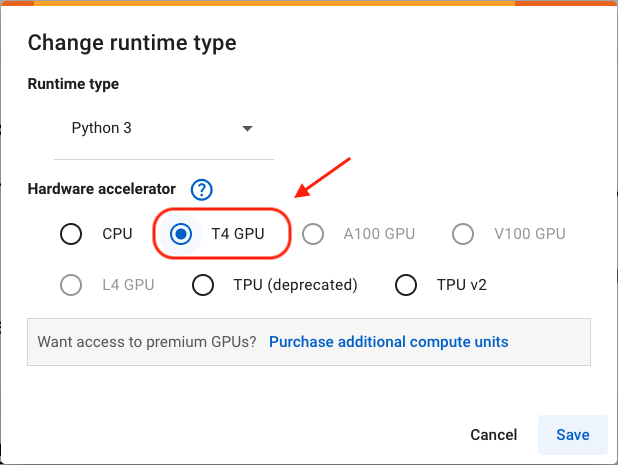

The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 814.8 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-72jyithi
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-72jyithi
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x8

In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.2.1+cu121


# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [3]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [4]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 338M/338M [00:01<00:00, 180MiB/s]


Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [5]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7dcaac0d57e0>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing/Endcoding (Tokenization)
In stead of directly let the CLIP model to directly learn/estimate the relation between `raw Text` and `Image`, we would `encode` it in form of `tokens` to let the computer understand the context of the given text better.

This process is up to the design of the model on how to represent the context. Some simple encoding are `n-grams` and `bag-of-words`. Hence this CLIP use `tensorFlow` encoding method.

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [6]:
# @title Convert `Text Sentence` -> `Tokens` { run: "auto", display-mode: "both" }

sentence = "A surprise face after seeing A+ grade in the Transcript" # @param {type:"string"}
clip.tokenize(sentence)

tensor([[49406,   320,  5099,  1710,   953,  3214,   320,   266,  3394,   530,
           518, 39008, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [7]:
! git clone https://github.com/H11Maitree/Facial-Expression-Classification-CLIP
face_sample_dir = "/content/Facial-Expression-Classification-CLIP/face_expression_sample"

Cloning into 'Facial-Expression-Classification-CLIP'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 16 (delta 0), reused 16 (delta 0), pack-reused 0
Receiving objects: 100% (16/16), 5.02 MiB | 16.17 MiB/s, done.


In [8]:
import os
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# gave our images textual descriptions
descriptions = {
    "angry": "a froeny angry face",
    "crazy": "a squinting crazy retarded face",
    "disgust": "a eye rolled-up death glare disgust face",
    "happy": "a asian smiling happy face",
    "neutral": "a formal ID picture a visa application",
    "pain": "a screaming in physical pain face",
    "surprise": "a face of a teenager when facing a unexpecting camera"
}

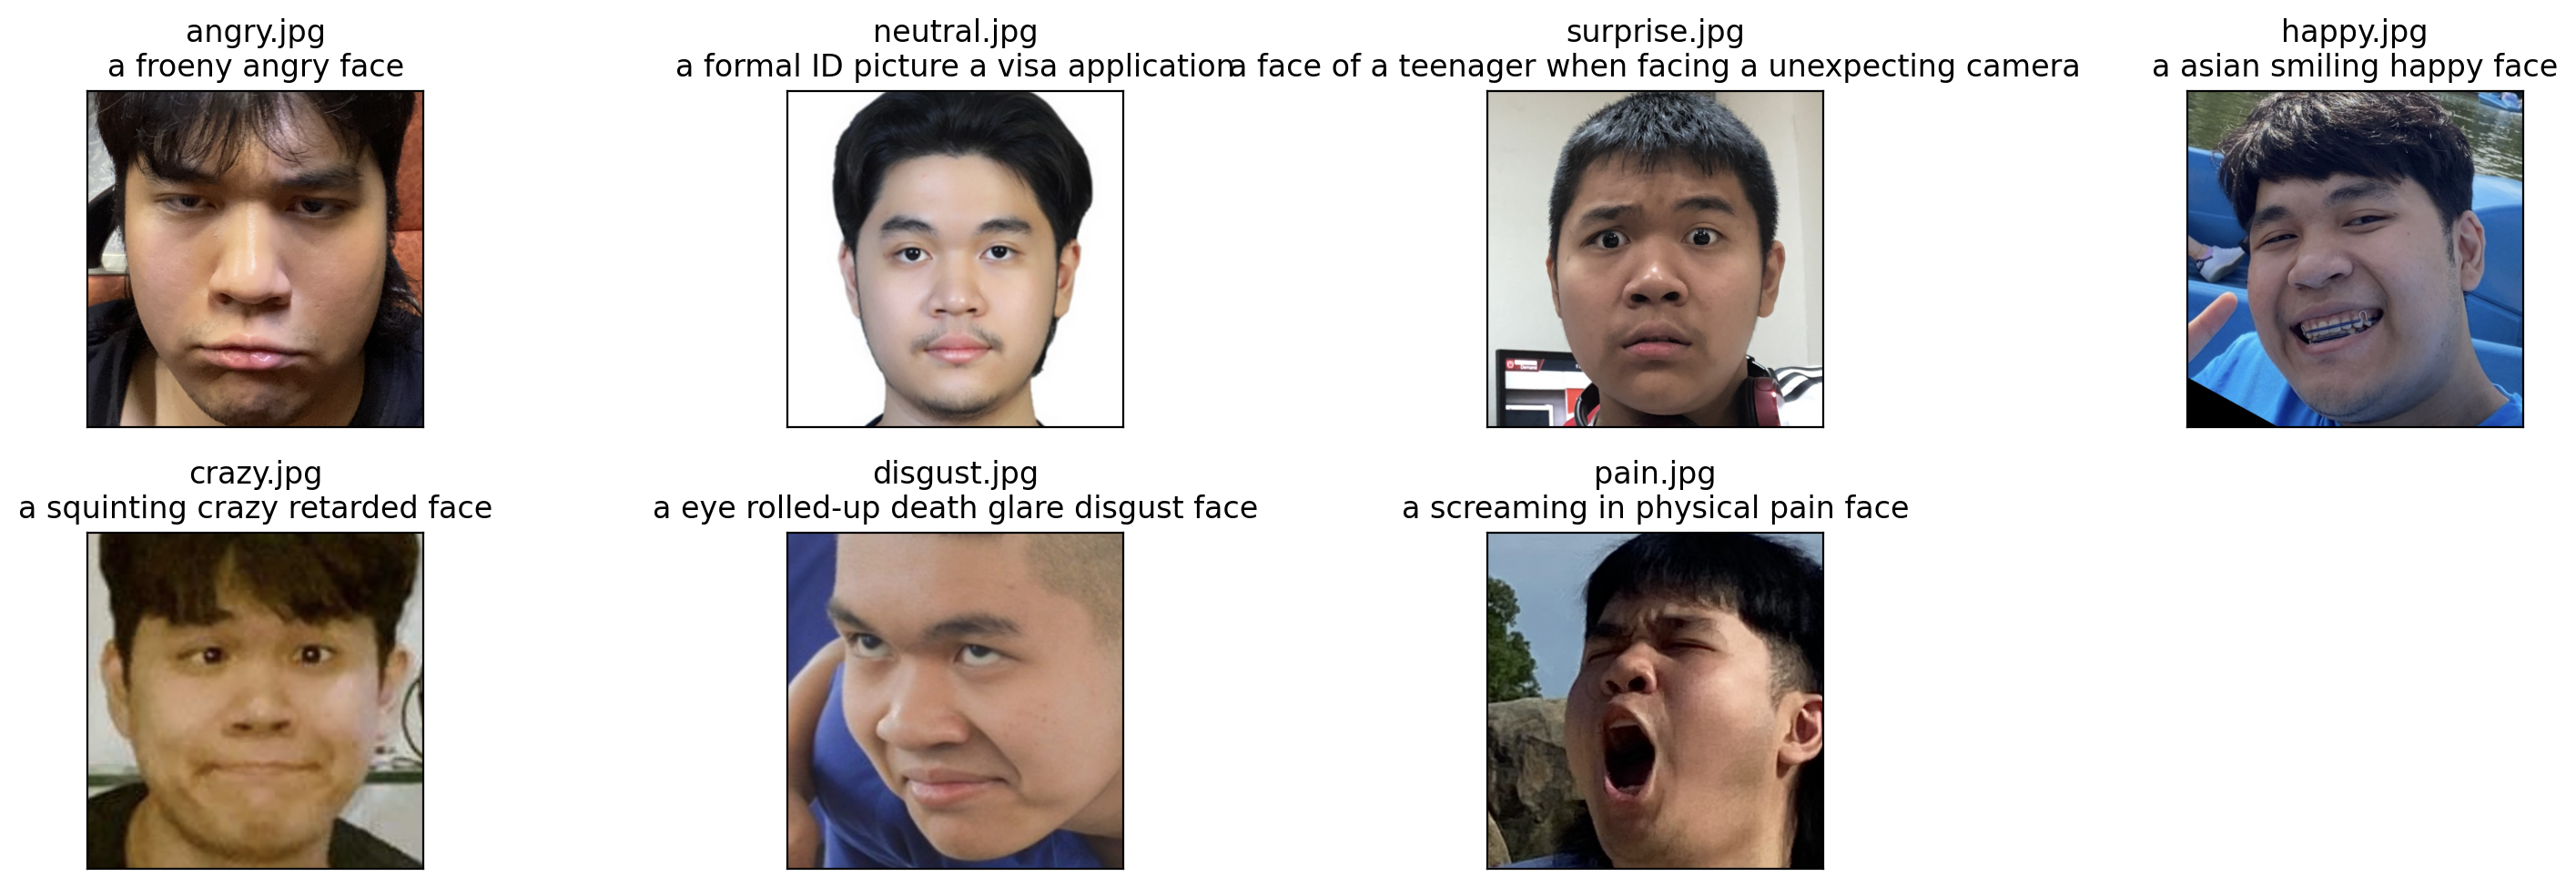

In [9]:
original_images = []
images = []
texts = []
ground_truth_label = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(face_sample_dir) if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    if name not in descriptions:
        continue

    image = Image.open(os.path.join(face_sample_dir, filename)).convert("RGB")

    plt.subplot(2, 4, len(images) + 1)
    plt.imshow(image)
    plt.title(f"{filename}\n{descriptions[name]}")
    plt.xticks([])
    plt.yticks([])

    original_images.append(image)
    images.append(preprocess(image))
    texts.append(descriptions[name])
    ground_truth_label.append(name)

plt.tight_layout()


## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

In [10]:
# @title Construct Prompt for Calculate Similarlity { run: "auto", display-mode: "both" }

def constructSimilarityCalculationPrompt(desc: str) -> str:
  before_desc = "This is " # @param {type:"string"}
  after_desc = "." # @param {type:"string"}
  return before_desc + desc + after_desc

print(f"{'Desc':<50}\tPrompt")
for desc in texts:
    prompt = constructSimilarityCalculationPrompt(desc)
    print(f"{desc:<50}\t{prompt}")

Desc                                              	Prompt
a froeny angry face                               	This is a froeny angry face.
a formal ID picture a visa application            	This is a formal ID picture a visa application.
a face of a teenager when facing a unexpecting camera	This is a face of a teenager when facing a unexpecting camera.
a asian smiling happy face                        	This is a asian smiling happy face.
a squinting crazy retarded face                   	This is a squinting crazy retarded face.
a eye rolled-up death glare disgust face          	This is a eye rolled-up death glare disgust face.
a screaming in physical pain face                 	This is a screaming in physical pain face.


In [11]:
image_input = torch.tensor(np.stack(images)).cuda()
text_tokens = clip.tokenize([constructSimilarityCalculationPrompt(desc) for desc in texts]).cuda()

In [12]:
with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()

## Calculating Cosine Similarity
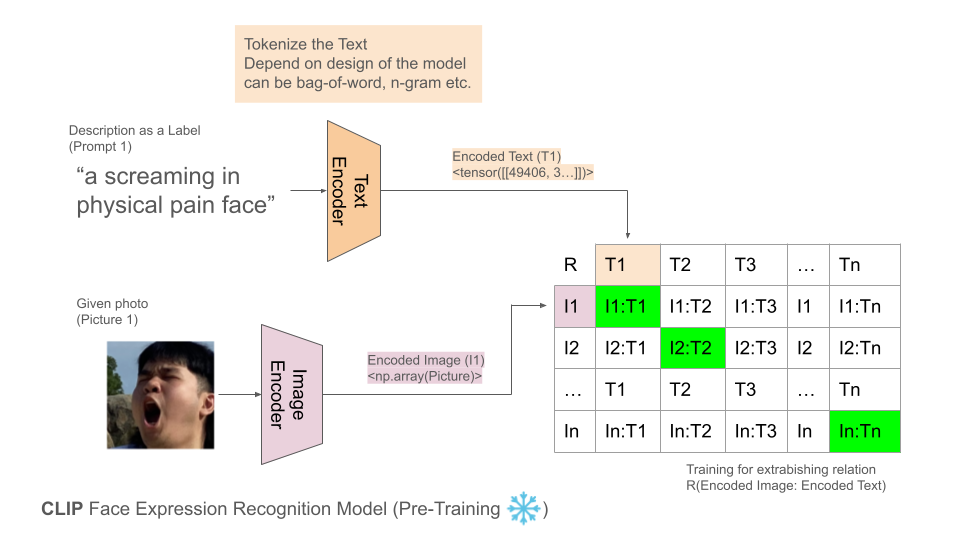

During the pre-traning of the CLIP model (cold traning, unseen from this notebook) trainer will fit large amont of `Text and Image Pair` forming the relationship between encoded Text and encoded Image.

Note that **during pre-traning phases no labels are needed**, these pre-tranied CLIP model we use to day are tranied on public domain data (scraping from internet Pictures and its' description) and unseen to our given labels later in the predicting process, making it `Zero-Shot`

However, today we will try our given prompt to see whether it follow the pre-trained model by previewing the similarlity scores between each `Text and Image Pair`.

Ideally the each pair should have the stong similarity score correspondingly.

### Example of the Ideal Similarity Matrix

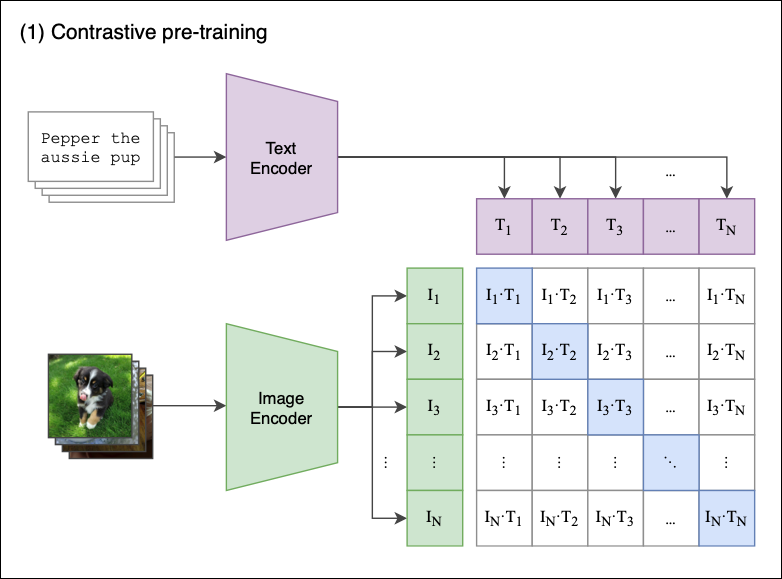

_Picture Source: [CLIP: Connecting text and images](https://openai.com/research/clip)_

We normalize the features and calculate the dot product of each pair.

In [13]:
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T

Text(0.5, 1.0, 'Cosine similarity between text description and image features')

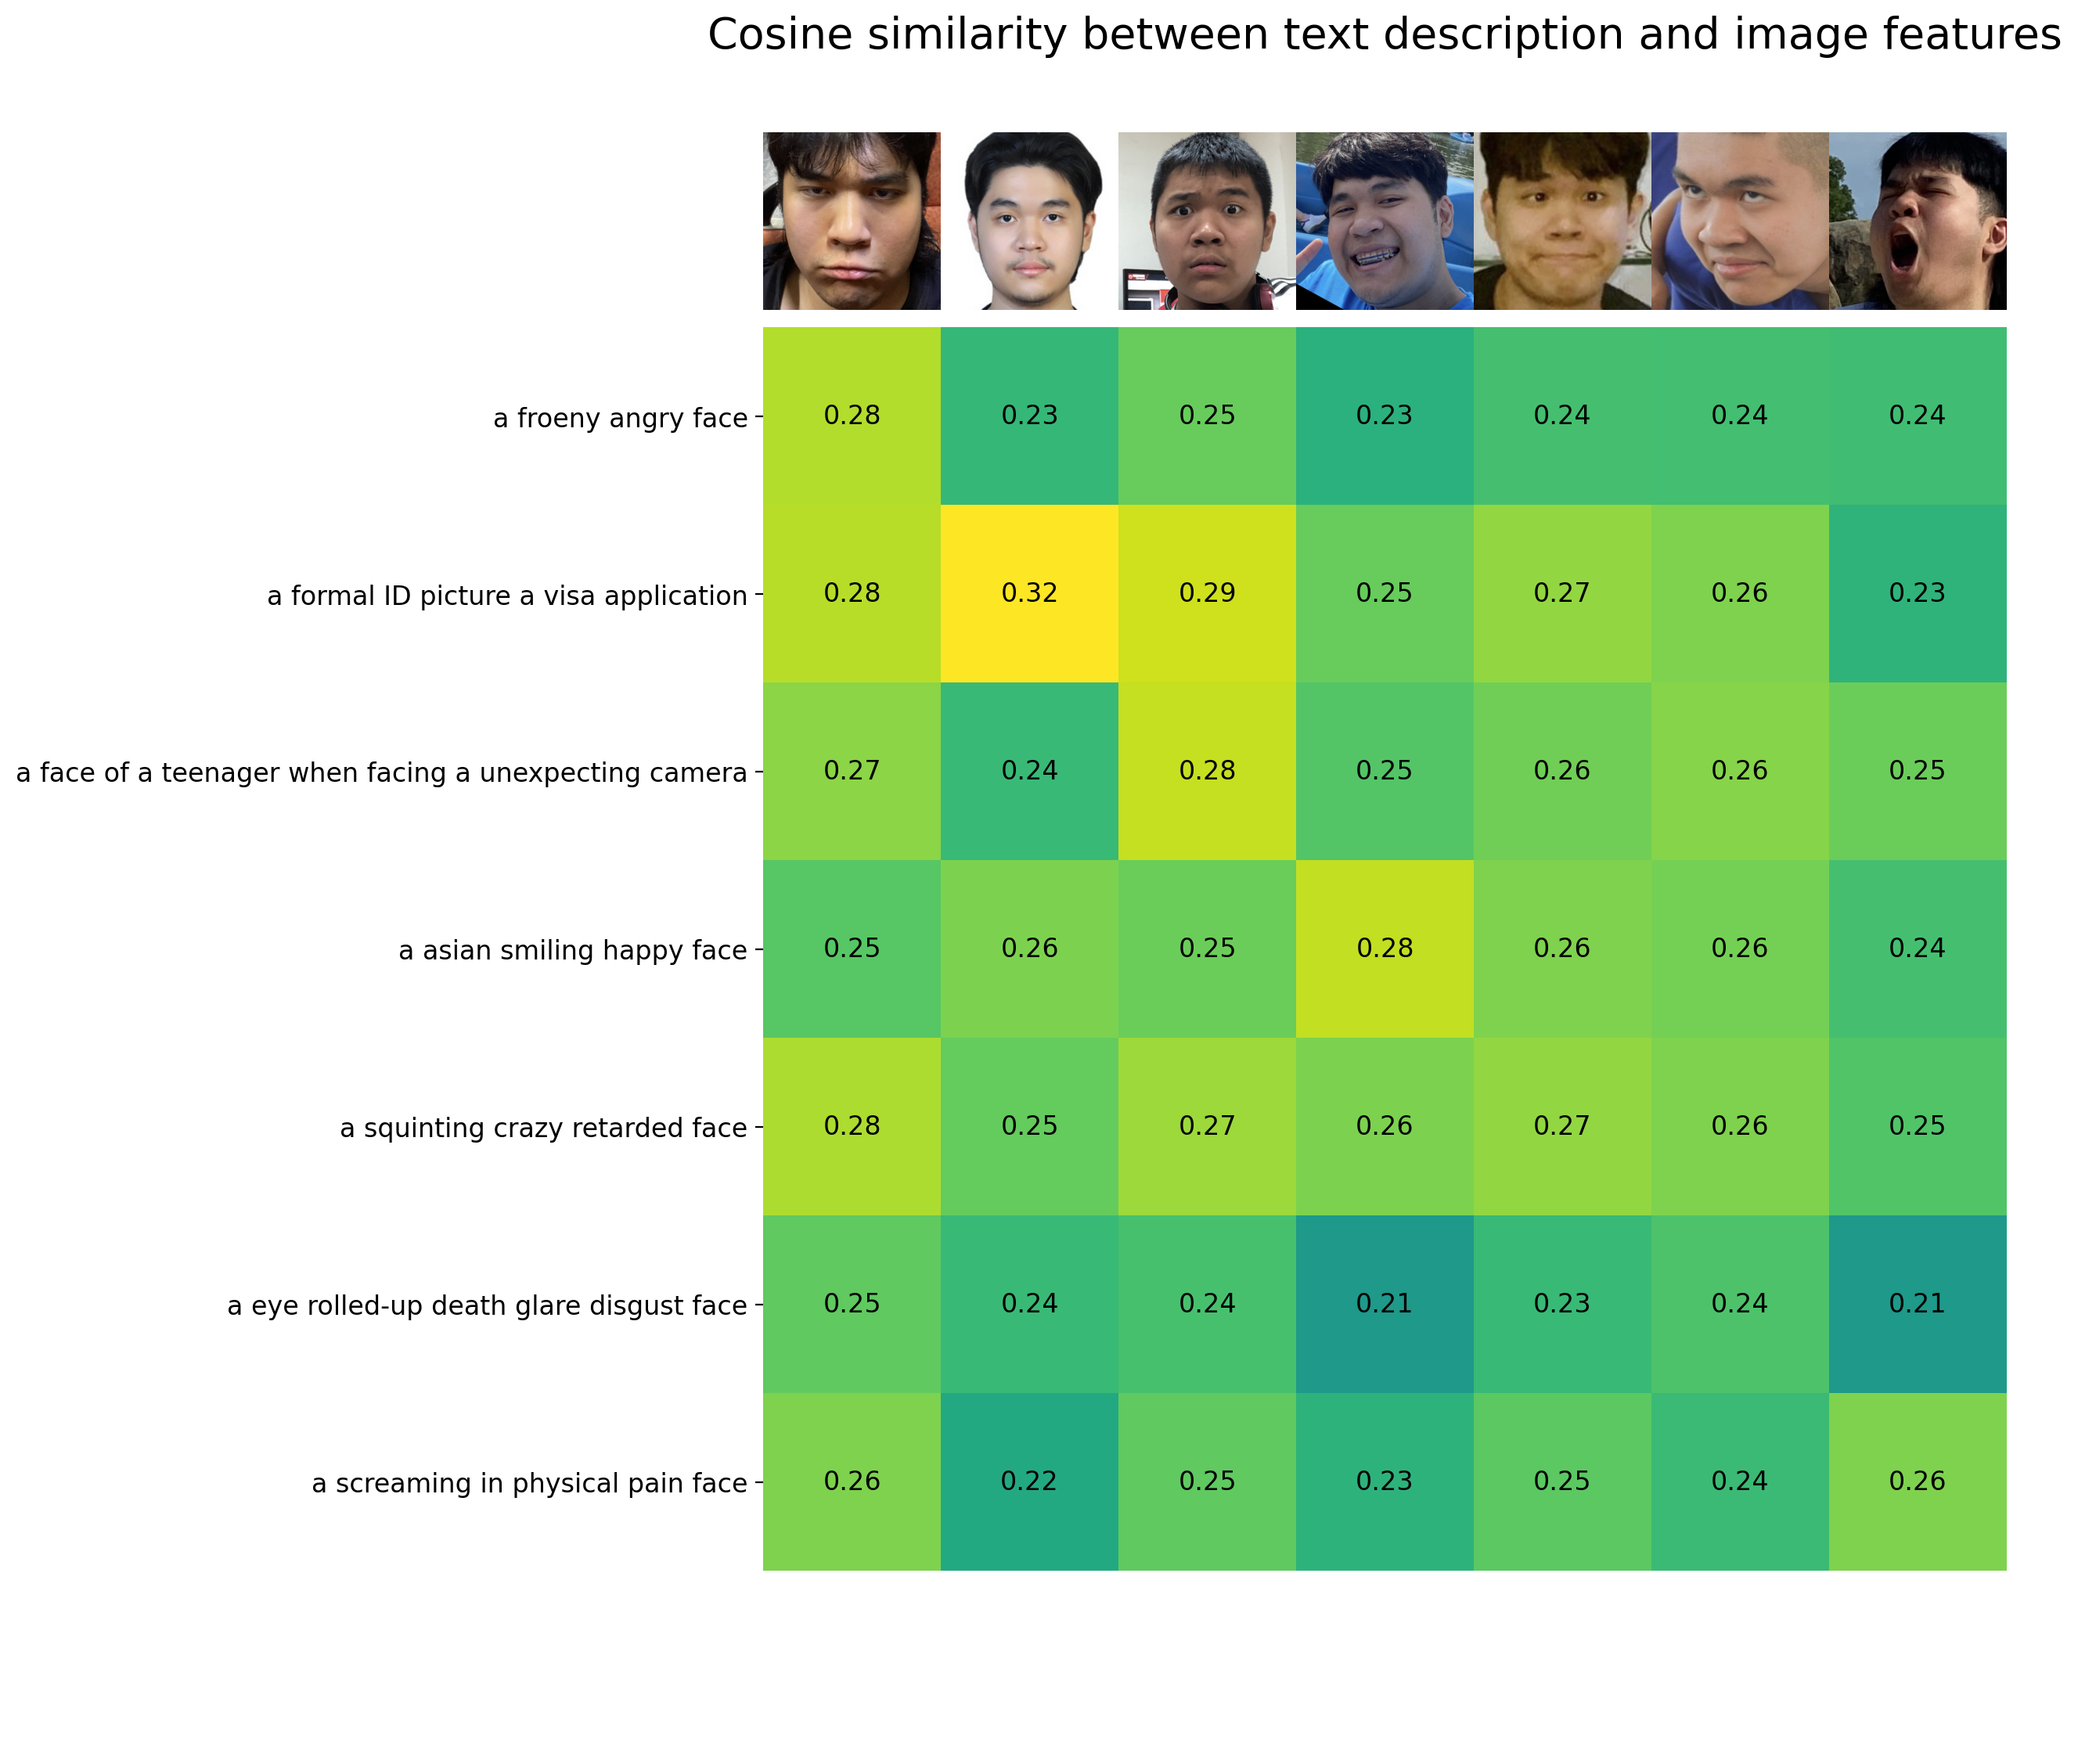

In [14]:
count = len(descriptions)

plt.figure(figsize=(20, 14))
plt.imshow(similarity, vmin=0.1, vmax=0.3)

plt.yticks(range(count), texts, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.2f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
  plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text description and image features", size=20)

# Zero-Shot Facial Expression Classification from Image

You can classify Facial Expression (based on Image) using the cosine similarity (times 100) as the logits to the softmax operation.

In [15]:
labels = ["angry", "crazy", "disgust", "happy", "neutral", "pain", "surprise"] # given the label list (classes)
ground_truth_label_index = [labels.index(label) for label in ground_truth_label if label in labels] # prepare expected result for each image

In [16]:
# @title Construct Prompt for Prediction { run: "auto", display-mode: "both" }

def constructPredictionPrompt(label: str) -> str:
  before_label = "This is a " # @param {type:"string"}
  after_label = " face." # @param {type:"string"}
  return before_label + label + after_label

print(f"{'Label':<50}\tPrompt")
for label in labels:
    prompt = constructPredictionPrompt(label)
    print(f"{label:<50}\t{prompt}")

Label                                             	Prompt
angry                                             	This is a angry face.
crazy                                             	This is a crazy face.
disgust                                           	This is a disgust face.
happy                                             	This is a happy face.
neutral                                           	This is a neutral face.
pain                                              	This is a pain face.
surprise                                          	This is a surprise face.


In [17]:
text_descriptions = [constructPredictionPrompt(label) for label in labels]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [18]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

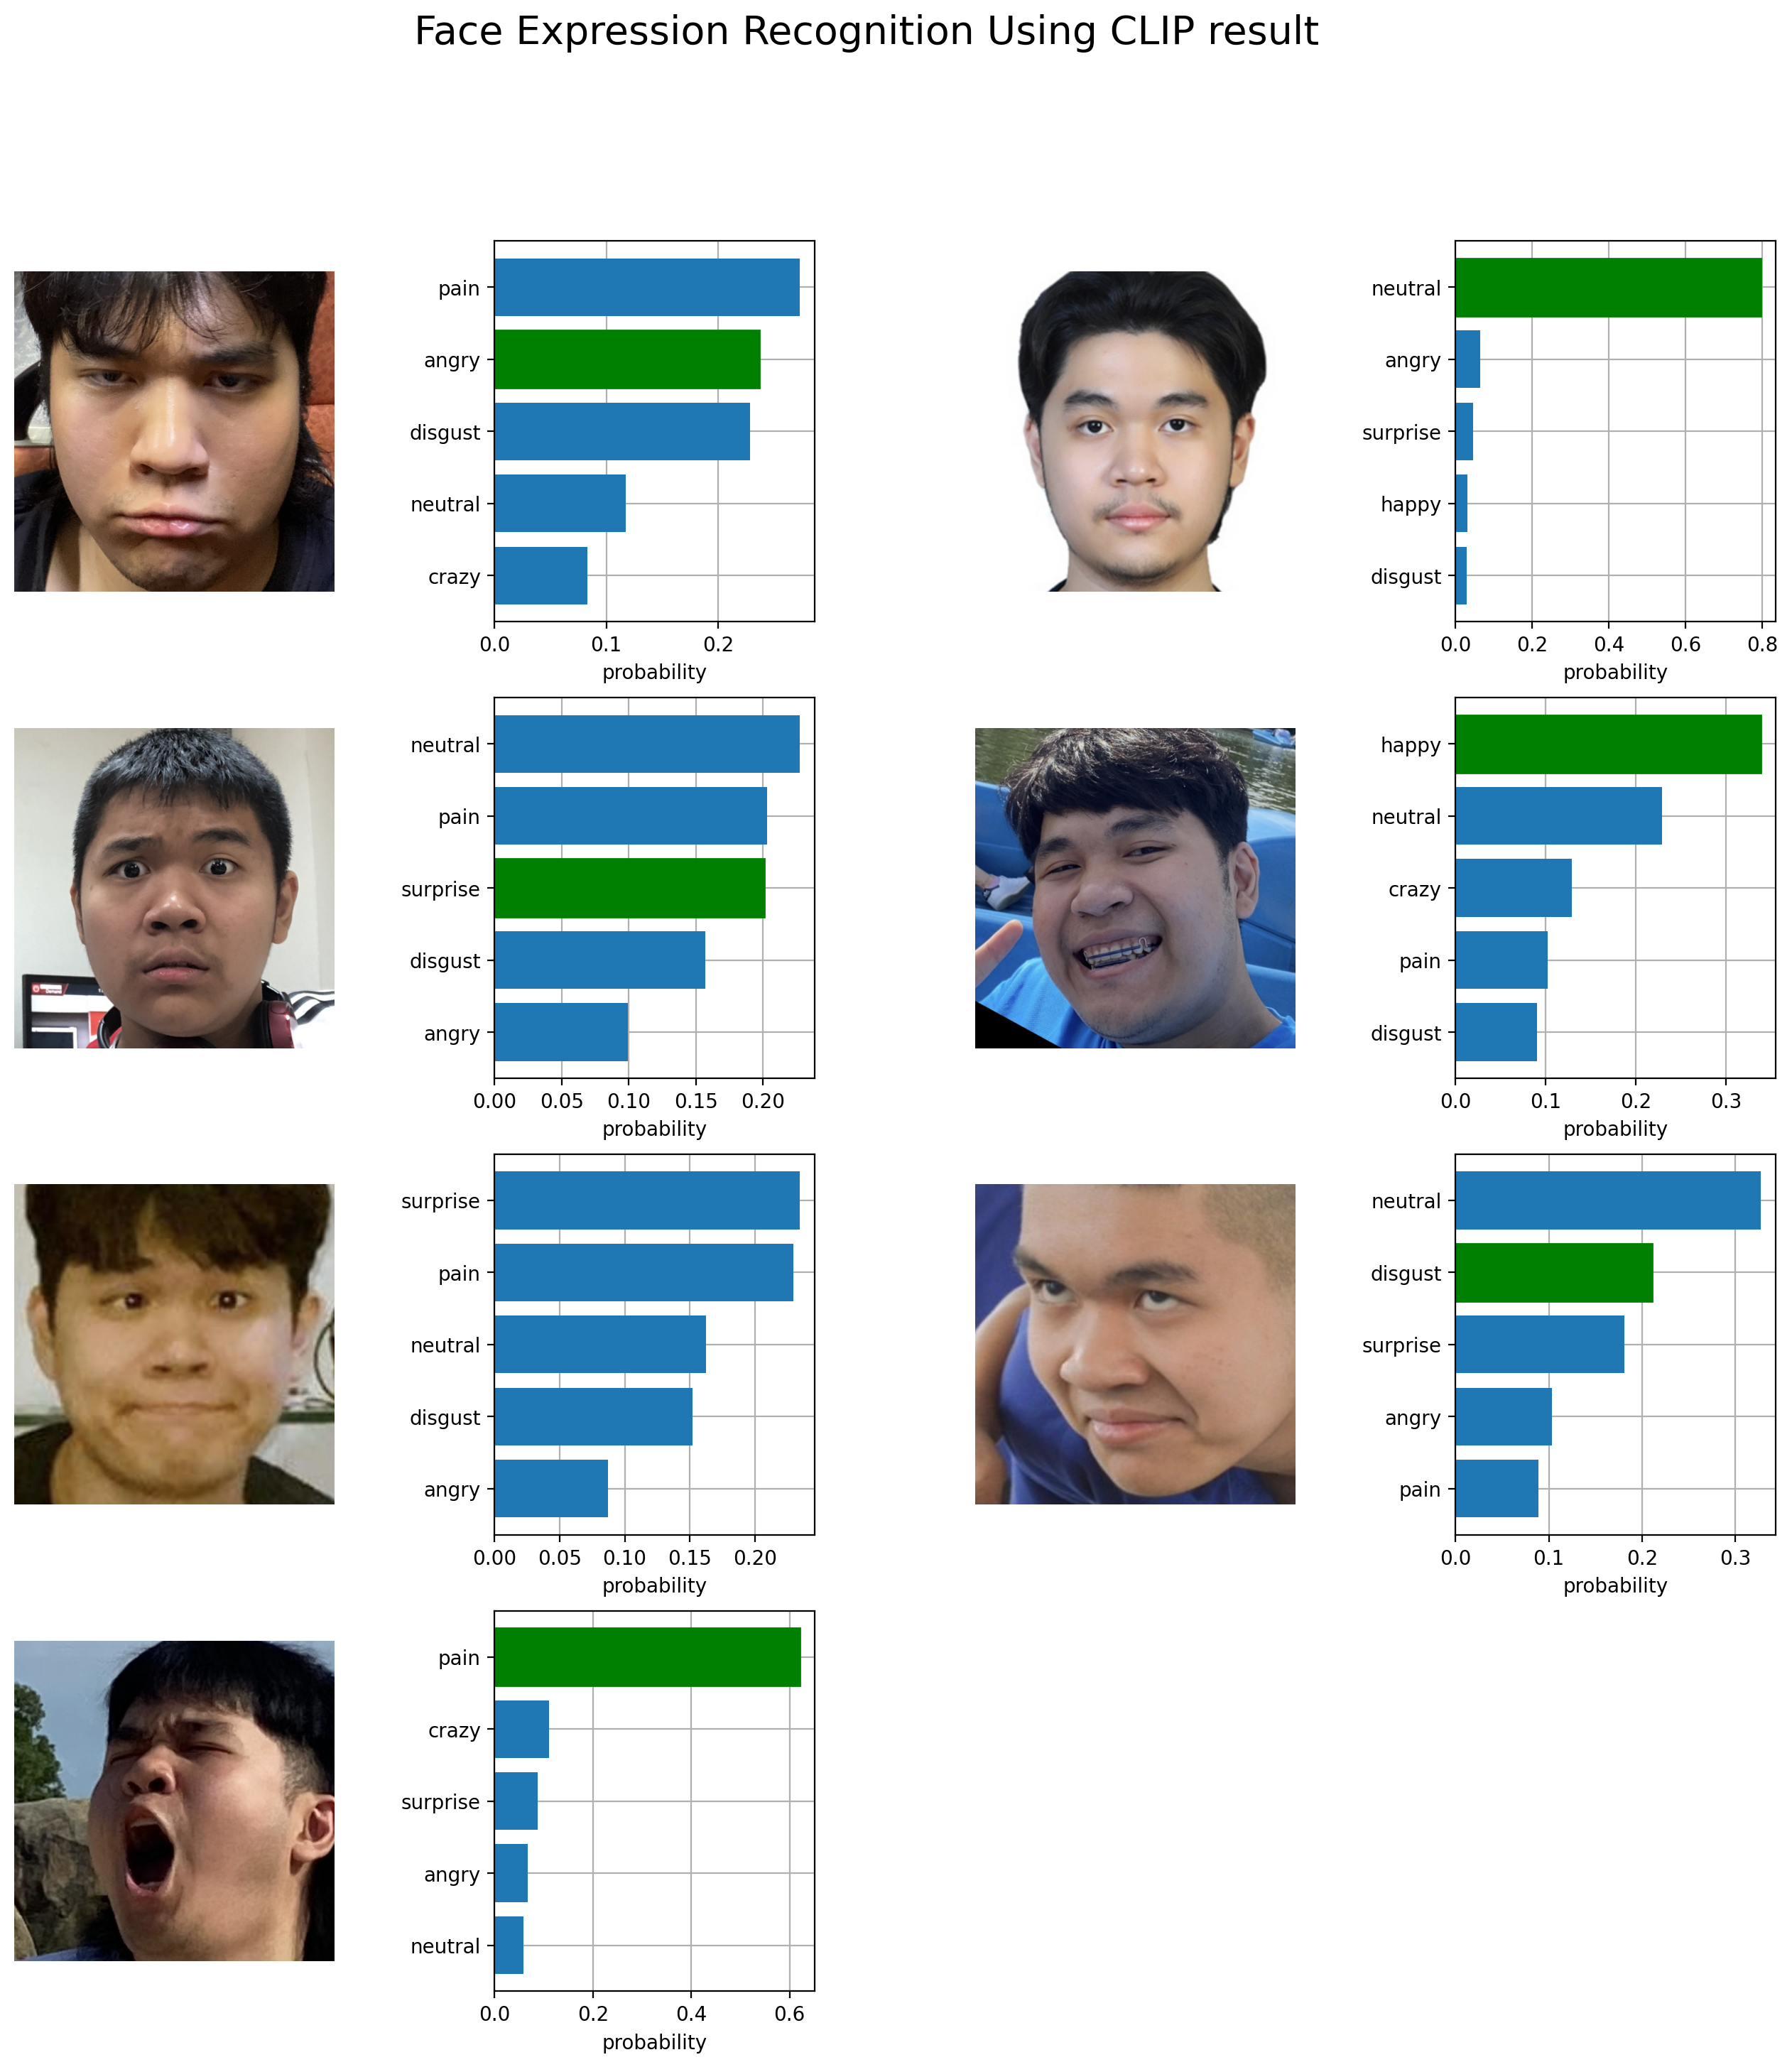

In [19]:
plt.figure(figsize=(16, 16))
plt.suptitle("Face Expression Recognition Using CLIP result", size=20)

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()

    bars = plt.barh(y, top_probs[i])

    def findCorrectBarIndex(top_label):
      for i_label in range(len(top_label)):
        if top_label[i_label] == ground_truth_label_index[i]:
          return i_label
      return None

    correctBarIndex = findCorrectBarIndex(top_labels[i])

    if correctBarIndex != None:
      bars[correctBarIndex].set_color('g')

    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [labels[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()